# NextstepRNN

Predict the next position (x,y) given the last position and the latent state of a RNN cell.

## ToDos:

* MLP trainieren können (nur mit seinem MAE kommen wir später an die Grenze)
* fake data generator -> mit steigendem aleatorischen Zufall -> wie gut matched das LSTM?
* data augmentation: tracks zerschneiden in tracklets? Wäre sinnvoll für data association, wenn ein Teilchen in der Mitte auftaucht
* initial_state lernen
* MLP trainieren zum Vergleich 
* box plots for all data, to compare with Tobias
* curriculum learning
* use `padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, padding='post')` for padding


In [1]:
# pin the tensorflow version
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass


# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
# !rm -rf ./logs/ 
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip -q install pandas
!{sys.executable} -m pip -q install sklearn
!apt-get -q install wget

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [2]:
import os
import io
import glob
import random
import time
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime

print('Tensorflow version:', tf.__version__)

tf.test.is_gpu_available()
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0


In [3]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

--2019-11-21 17:51:42--  https://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘Pfeffer.zip’ not modified on server. Omitting download.



In [4]:
# DATA LOADING
#
# The downloaded folder contains .csv-files which contain two columns per track.
# for example "TrackID_4_X" and "TrackID_4_Y".
# The code in this cell loads the tracks from the files and puts them into a 
# zero padded tensor with the shape: [num_tracks, num_time_steps, input_dim*2]
# Note: The "shifted" versions of the file seem to use one timestamps at a row.
#       This is not interesting for us.
#
# For every timestep the tensor contains: [x_t, y_t, x_{t+1}, y_{t+1}] where
#  t is the time step. 

# data loading parameter
num_time_steps = 35 # ToDo: Evaluate max length. 50
nan_value = 0
input_dim = 2

# collect all tracks from the files
tracks = []

file_list = sorted(glob.glob('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv'))

for file_ in file_list:
  # read the tracks from one measurement
  # ToDo: use tf.data.experimental.CsvDataset instead?
  df = pd.read_csv(file_)
  # remove columns with less then 6 detections (same as Tobias did)
  df.dropna(axis=1, thresh=6, inplace=True)
  # there are two columns per track, for example "TrackID_4_X" and "TrackID_4_Y"
  number_of_tracks = int((df.shape[1]) / 2)

  # We wan't to use 0.0 as NaN value. Therefore we have to check that it does not
  #   exist in the data.   Note: the double .min().min() is necessary because we
  #   first get the column minima and then we get the table minimum from that
  assert df.min().min() > 0.0, f"Error: The dataframe {file_} contains a minimum <= 0.0"

  # for every track we create:
  #  x, y, x_target, y_target zero padded
  for track_number in range(number_of_tracks):
    x = df.iloc[:, (2 * track_number)].to_numpy(copy=True)
    x = np.concatenate((x[:-1], np.array([nan_value])))
    y = df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)
    y = np.concatenate((y[:-1], np.array([nan_value])))
    
    # remove the last input because we have no target for it
    last_index = np.where(np.isnan(x))[0][0] - 1
    x[last_index] = np.nan
    y[last_index] = np.nan

    # the ground truth where the particle will be afterwards
    x_target = np.concatenate( ( df.iloc[:, (2 * track_number)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )
    y_target = np.concatenate( ( df.iloc[:, (2 * track_number + 1)].to_numpy(copy=True)[1:], np.array([nan_value]) ) )

    input_matrix = np.vstack((x, y, x_target, y_target))
    input_matrix = np.nan_to_num(input_matrix, nan=nan_value)
    input_matrix = input_matrix

    # initialize the array with zeros
    matrix = np.zeros([num_time_steps, input_dim*2])

    # insert the data of the track into the zero "black" background
    matrix[0:x.size, 0:input_dim*2] = input_matrix.T

    tracks.append(matrix)

tracks = np.array(tracks)
print(tracks.shape)

(6963, 35, 4)


In [5]:
# Normalization
#
# For later use we have to store x_max and y_max in order to 
# apply and revert normalization. It might also be enough to
# set constant values like 2500 and 2000.

# normalize (x distinct of y)
x_max = np.nanmax(tracks[:, :, [0, 2]])
y_max = np.nanmax(tracks[:, :, [1, 3]])
print(f'x_max: {x_max} and y_max: {y_max}')

x_max = 2182
y_max = x_max

print(f"Overwriting with constant values: x_max={x_max}, y_max={y_max}")


# now all values are in [0, 1.0]
tracks[:, :, [0, 2]] /= x_max
tracks[:, :, [1, 3]] /= y_max

x_max: 2181.72 and y_max: 1678.9327
Overwriting with constant values: x_max=2182, y_max=2182


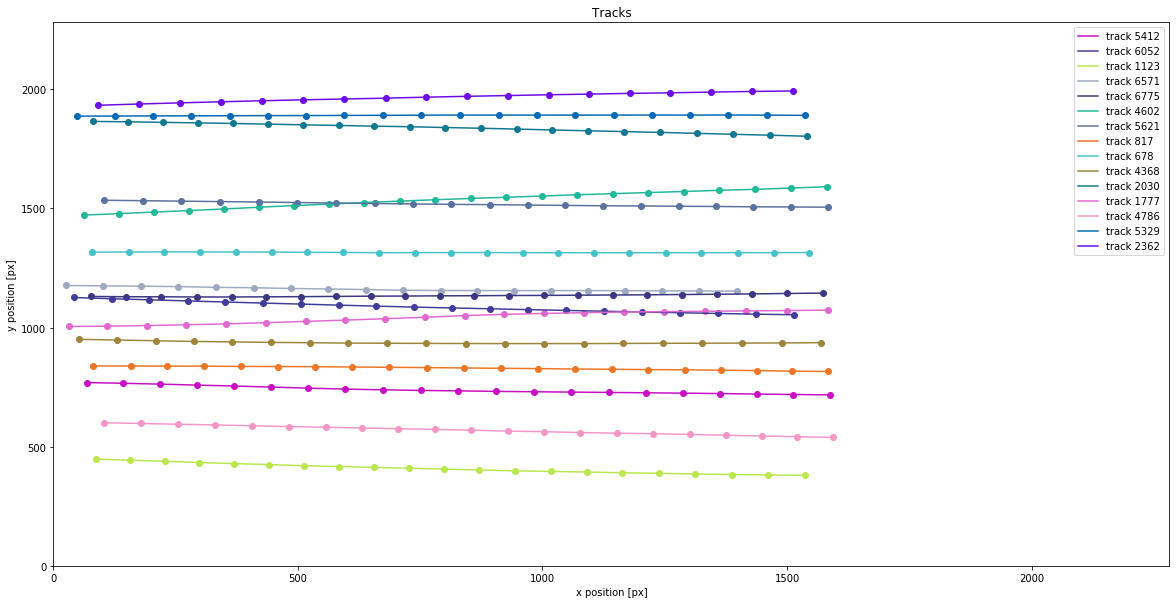

In [6]:
# track visualization
def plot_track(track, color='black', start=0, end=-1, label='track'):
    track = track[start:end]

    axes = plt.gca()
    axes.set_xlim([0, x_max + 100])
    axes.set_ylim([0, y_max + 100])

    plt.xlabel('x position [px]')
    plt.ylabel('y position [px]')
    axes.scatter(track[:, 1] * x_max, track[:, 0] * y_max, color=color)
    axes.plot(track[:, 1] * x_max, track[:, 0] * y_max, color=color, label=label)
    axes.legend()

    return axes

def get_last_timestep_of_track(track):
    for i in range(track.shape[0]):
        if not np.any(track[i]):
            return i
    return i
  
for _ in range(15):
    random_index = random.randint(0, tracks.shape[0] - 1)
    random_track = tracks[random_index]
    axes = plot_track(random_track, color=np.random.rand(3), 
                    end=get_last_timestep_of_track(random_track),
                    label=f'track {random_index}')
    plt.title(f'Tracks')
plt.show()

In [7]:
# split into train and test splits
test_split_size = 0.1

train_tracks, test_tracks = train_test_split(tracks, test_size=test_split_size)

In [8]:
# Tensorflow Dataset API

# Training examples
batch_size = 128

output_types = tuple([tf.float64, tf.float64, tf.float64, tf.float64])

# ToDo: use .from_generator(...) instead, because .from_tensor_slices(..) calls python code
# raw_train_dataset = tf.data.Dataset.from_generator(lambda: train_tracks, output_types)
# raw_test_dataset = tf.data.Dataset.from_generator(lambda: test_tracks, output_types)
raw_train_dataset = tf.data.Dataset.from_tensor_slices(train_tracks)
raw_test_dataset = tf.data.Dataset.from_tensor_slices(test_tracks)

# for optimal shuffling the shuffle buffer has to be of the size of the number
# of tracks
minibatches_train = raw_train_dataset.shuffle(train_tracks.shape[0]).batch(batch_size, drop_remainder=True)
minibatches_test = raw_test_dataset.shuffle(test_tracks.shape[0]).batch(batch_size, drop_remainder=True)

# We want to train the RNN to solve a Seq2Seq problem:
# For each sequence:
#  - duplicate it
#  - and shift it to form the input and target sequence
#    by using the map method

def split_input_target(chunk):
    # split the tensor (x, y, x_target, y_target) 
    #  -> into two tensors (x, y) and (x_target, y_target)
    input_seq =  chunk[:, :, :2]
    target_seq = chunk[:, :, 2:]
    return input_seq, target_seq

dataset_train = minibatches_train.map(split_input_target)
dataset_test = minibatches_test.map(split_input_target)

In [9]:
# data augmentation on the training data

@tf.function
def augment(input_seq: tf.Tensor, target_seq:tf.Tensor) -> tf.Tensor:
    # ToDo: what makes sense and does not destroy the masking?
    random_float = tf.random.normal([1], mean=1.0, stddev=0.1, dtype=tf.float64)
    return input_seq * random_float, target_seq * random_float

# dataset_train.map(augment)

In [10]:
# HParams Dashboard for Tensorboard
# -> used for hyperparameter optimization

# *Attention:* If something is changed here, then a new directory for logging is necessary
#    because HParams cannot adapt dynamically to changing HParams

HP_NUM_UNITS_FIRST_LSTM = hp.HParam('num_units_first_lstm', hp.Discrete([16, 32, 64, 128, 256, 512]))
HP_NUM_UNITS_SECOND_LSTM = hp.HParam('num_units_second_lstm', hp.Discrete([16, 32, 64, 128, 256, 512, 1024]))
HP_NUM_UNITS_THIRD_LSTM = hp.HParam('num_units_third_lstm', hp.Discrete([0]))
HP_NUM_UNITS_FOURTH_LSTM = hp.HParam('num_units_fourth_lstm', hp.Discrete([0]))
LSTM_LAYERS = [HP_NUM_UNITS_FIRST_LSTM, HP_NUM_UNITS_SECOND_LSTM, HP_NUM_UNITS_THIRD_LSTM, HP_NUM_UNITS_FOURTH_LSTM]

HP_NUM_UNITS_FIRST_DENSE = hp.HParam('num_units_first_dense', hp.Discrete([16, 32, 64, 128, 256]))
HP_NUM_UNITS_SECOND_DENSE = hp.HParam('num_units_second_dense', hp.Discrete([0, 16, 32, 64, 128]))
HP_NUM_UNITS_THIRD_DENSE = hp.HParam('num_units_third_dense', hp.Discrete([0]))
HP_NUM_UNITS_FOURTH_DENSE = hp.HParam('num_units_fourth_dense', hp.Discrete([0]))
DENSE_LAYERS = [HP_NUM_UNITS_FIRST_DENSE, HP_NUM_UNITS_SECOND_DENSE, HP_NUM_UNITS_THIRD_DENSE, HP_NUM_UNITS_FOURTH_DENSE]

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
LEAKY_RELU_ALPHA = hp.HParam('leaky_relu_alpha', hp.Discrete([0.2]))
DENSE_BATCH_NORM = hp.HParam('use_batchnorm_on_dense', hp.Discrete([True]))
LR_DECAY_AFTER_EPOCHS = hp.HParam('lr_decay_after_epochs', hp.Discrete([100]))

METRIC_MSE = 'mse'
METRIC_MAE = 'mae'

ALL_HPARAMS = [LR_DECAY_AFTER_EPOCHS] + LSTM_LAYERS + DENSE_LAYERS + [DENSE_BATCH_NORM, LEAKY_RELU_ALPHA, HP_OPTIMIZER]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=ALL_HPARAMS,
        metrics=[
            hp.Metric(METRIC_MSE, display_name='MSE'),
            hp.Metric(METRIC_MAE, display_name='MAE'),
        ],
    )

In [11]:
# model factory
def model_factory(hparams):
    """
    Create a new keras model with the sequential API
    
    Params:
    Returns:
        - model
        - hash string identifying the architecture uniquely
    """
    model = tf.keras.Sequential()
    
    # hash for the model architecture
    hash_ = 'v1'

    # The Masking makes the model ignore timesteps where the whole vector
    # consists of the *mask_value* 
    model.add(tf.keras.layers.Masking(mask_value=nan_value, name="masking_layer", 
                                      batch_input_shape=(batch_size, num_time_steps, input_dim)))
    hash_ += f"-masking"
    
    # Add the LSTM layers
    for lstm_layer in LSTM_LAYERS:
        if hparams[lstm_layer] == 0:
            # as soon as one layer has no units, we don't create the layer.
            break
        else:
            hash_ += f"-lstm[{hparams[lstm_layer]}]"
            model.add(tf.keras.layers.LSTM(hparams[lstm_layer], 
                                            return_sequences=True, 
                                            stateful=False, 
                                            unroll=True,
                                            recurrent_initializer='glorot_uniform'))
    
    # Add the dense layers
    for dense_layer in DENSE_LAYERS:
        if hparams[dense_layer] == 0:
            # as soon as one layer has no units, we don't create the layer.
            break
        else:
            hash_ += f"-dense[{hparams[dense_layer]}, leakyrelu={hparams[LEAKY_RELU_ALPHA]}]"
            model.add(tf.keras.layers.Dense(hparams[dense_layer]))
            model.add(tf.keras.layers.LeakyReLU(alpha=hparams[LEAKY_RELU_ALPHA]))
            if hparams[DENSE_BATCH_NORM]:
                model.add(tf.keras.layers.BatchNormalization())
                hash_ += "-BatchNorm"
    
    # Always end with a dense layer with two outputs (x, y)
    model.add(tf.keras.layers.Dense(2))
    
    hash_ += f"-dense[2]"

    return model, hash_


In [17]:
%tensorboard --logdir logs_third --host 0.0.0.0 --port 6006

In [12]:
# make some graphics to evaluate qualitatively
def plot_tracks(n=5, step=1, display=False):
    for input_example_batch, target_example_batch in dataset_test.take(1):
        # hidden = model.reset_states()
        example_batch_predictions = model(input_example_batch)
        for i in range(n):
            seq_length = get_last_timestep_of_track(input_example_batch[i])
            axes = plot_track(input_example_batch[i], color='black', end=seq_length, label=f"Input truth {i}")
            axes = plot_track(target_example_batch[i], color='green', end=seq_length, label=f"Output truth {i}")
            axes = plot_track(example_batch_predictions[i], color='blue', end=seq_length, label=f"NextStep-RNN {i}")
            plt.title(f'Track with predictions [test data]')

        # store plot in memory buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # add batch dim
        image = tf.expand_dims(image, 0)
        tf.summary.image("plot", image, step=step)

        if display:
            plt.show()
        else:
            plt.clf()

In [13]:
# Calc MSE and MAE in Computational Graph!

def tf_error(model, dataset, squared=True):
    
    # the placeholder character used for padding
    mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
    
    @tf.function
    def f():
        # AutoGraph has special support for safely converting for loops when y is a tensor or tf.data.Dataset.
        # https://www.tensorflow.org/tutorials/customization/performance
        
        loss = tf.constant(0, dtype=tf.float64)
        
        for input_batch, target_batch in dataset: 
            # reset state
            hidden = model.reset_states()
            
            batch_predictions = model(input_batch)            
        
            # Calculate the mask
            mask = K.all(K.equal(target_batch, mask_value), axis=-1)
            mask = 1 - K.cast(mask, tf.float64)
            mask = K.cast(mask, tf.float64)
            
            # Revert the normalization
            # ToDo: Replace this hacky solution with same normalization in both directions
            #    with usage of x_max and y_max   with tf.scatter_nd_update(...)
            target_batch_unnormalized = target_batch * x_max
            pred_batch_unnormalized = batch_predictions * x_max

            # multiply categorical_crossentropy with the mask
            if squared:
                batch_loss = tf.keras.losses.mean_squared_error(target_batch_unnormalized, pred_batch_unnormalized) * mask
            else:
                batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask

            # take average w.r.t. the number of unmasked entries
            loss += K.sum(batch_loss) / K.sum(mask)
            
        return loss
    
    return f


In [14]:
# Custom training in computational graph

def train_step_generator():
    
    # the placeholder character used for padding
    mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
    
    @tf.function
    def train_step(inp, target):
        with tf.GradientTape() as tape:
            target = K.cast(target, tf.float64)
            predictions = model(inp)

            mask = K.all(K.equal(target, mask_value), axis=-1)
            mask = 1 - K.cast(mask, tf.float64)
            mask = K.cast(mask, tf.float64)

            # multiply categorical_crossentropy with the mask
            loss = tf.keras.losses.mean_squared_error(target, predictions) * mask

            # take average w.r.t. the number of unmasked entries
            loss = K.sum(loss) / K.sum(mask)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return loss
    
    return train_step

In [15]:
def get_name_for_experiment():
    now = datetime.now() # current date and time
    datetime_string = now.strftime("%Y-%m-%d--%H-%M-%S")
    return datetime_string

In [16]:
EPOCHS = 400
EVAL_EVERY_NTH_EPOCH = 50
SAVE_WEIGHTS = False
CREATE_PLOTS = True

num_experiment = 0
total_num_experiments = len(list(itertools.product(*[param.domain.values for param in ALL_HPARAMS])))

# list containing all built models
hash_list = set()

# iterate over all possible hyperparameter combinations
for hparam_values in itertools.product(*[param.domain.values for param in ALL_HPARAMS]):
    # parameters of current run: dict(HPARAM -> value)
    hparams = dict(zip(ALL_HPARAMS, hparam_values))

    run_name = get_name_for_experiment()
    print(f'--- Starting experiment {num_experiment}/{total_num_experiments}: {run_name}')
    print({h.name: hparams[h] for h in hparams})
    run_dir = 'logs/hparam_tuning/' + run_name

    step = 0
    
    model, hash_ = model_factory(hparams)
    print(f"Hash: {hash_}")
    if hash_ in hash_list:
        print("---> Skipping model because hash already used")
        continue  
    hash_list.add(hash_)
    
    best_mse = float("inf")
    best_mae = float("inf")

    # run the training and evaluation for one model
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        
        # print(model.summary())
        # Tensorflow graphs built for the training and evaluation
        #   they are reused. We don't want to create a new graph with every epoch.
        train_step = train_step_generator()
        calc_mse_train = tf_error(model, dataset_train, squared=True)
        calc_mse_test = tf_error(model, dataset_test, squared=True)
        calc_mae_train = tf_error(model, dataset_test, squared=False)
        calc_mae_test = tf_error(model, dataset_test, squared=False)

        # optimizer = 'adam'  # tf.keras.optimizers.Adam(learning_rate=hparams[HP_INITIAL_LR])
        optimizer = tf.keras.optimizers.Adam()

        for epoch in range(EPOCHS):
            # initializing the hidden state at the start of every epoch. initally hidden is None
            hidden = model.reset_states()

            # learning rate decay
            if (epoch+1) % hparams[LR_DECAY_AFTER_EPOCHS] == 0:
                old_lr = K.get_value(optimizer.lr)
                new_lr = old_lr * 0.1
                # print(f"Reducing learning rate from {old_lr} to {new_lr}.")
                print("R", end='')
                K.set_value(optimizer.lr, new_lr)

            for (batch_n, (inp, target)) in enumerate(dataset_train):
                hidden = model.reset_states()
                loss = train_step(inp, target)                    
                step += batch_size
            # print('Epoch {}/{} Loss {}'.format(epoch+1, EPOCHS, loss))
            tf.summary.scalar('training_loss', loss, step=step)

            print(".", end='')
            
            if (epoch + 1) % EVAL_EVERY_NTH_EPOCH == 0 or (epoch + 1) == EPOCHS:
                # train_mse = calculate_mse_test(model, dataset_train)
                # test_mse = calculate_mse_test(model, dataset_test)
                train_mse = calc_mse_train()
                test_mse = calc_mse_test()
                train_mae = calc_mae_test()
                test_mae = calc_mae_test()

                tf.summary.scalar('mse_train', train_mse, step=step)
                tf.summary.scalar('mse_test', test_mse, step=step)
                tf.summary.scalar('mae_train', train_mae, step=step)
                tf.summary.scalar('mae_test', train_mae, step=step)
                tf.summary.scalar('learning_rate', K.get_value(optimizer.lr), step=step)
                
                if CREATE_PLOTS:
                    plot_tracks(step=step)
                
                print("E", end='')
                
                # only store the best mse and mae (early stopping like)
                if test_mae < best_mae or test_mse < best_mse:
                    best_mae = test_mae
                    best_mse = test_mse
                
                tf.summary.scalar(METRIC_MSE, best_mse, step=1)
                tf.summary.scalar(METRIC_MAE, best_mae, step=1)
                
                if SAVE_WEIGHTS:
                    model.save_weights(checkpoint_prefix.format(epoch=epoch))
    print("")
    num_experiment += 1
        
    # clear after training
    K.clear_session()  
        


--- Starting experiment 0/1050: 2019-11-21--17-53-47
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 16, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 16, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[16]-dense[16, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 1/1050: 2019-11-21--17-58-27
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_un

Hash: v1-masking-lstm[16]-lstm[16]-dense[32, leakyrelu=0.2]-BatchNorm-dense[128, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 10/1050: 2019-11-21--18-40-46
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 16, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 64, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[16]-dense[64, leakyrelu=0.2]-BatchNorm-dense[2]
...

Hash: v1-masking-lstm[16]-lstm[16]-dense[128, leakyrelu=0.2]-BatchNorm-dense[64, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 19/1050: 2019-11-21--19-23-10
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 16, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 128, 'num_units_second_dense': 128, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[16]-dense[128, leakyrelu=0.2]-BatchNorm-dense[12

Hash: v1-masking-lstm[16]-lstm[32]-dense[16, leakyrelu=0.2]-BatchNorm-dense[32, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 28/1050: 2019-11-21--20-08-04
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 32, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 16, 'num_units_second_dense': 64, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[32]-dense[16, leakyrelu=0.2]-BatchNorm-dense[64, le

Hash: v1-masking-lstm[16]-lstm[32]-dense[64, leakyrelu=0.2]-BatchNorm-dense[16, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 37/1050: 2019-11-21--20-51-18
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 32, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 64, 'num_units_second_dense': 32, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[32]-dense[64, leakyrelu=0.2]-BatchNorm-dense[32, le

Hash: v1-masking-lstm[16]-lstm[32]-dense[256, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 46/1050: 2019-11-21--21-36-41
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 32, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 256, 'num_units_second_dense': 16, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[32]-dense[256, leakyrelu=0.2]-BatchNorm-dense[16, leakyrelu=0.2]-BatchNorm-dense[2]


Hash: v1-masking-lstm[16]-lstm[64]-dense[16, leakyrelu=0.2]-BatchNorm-dense[128, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 55/1050: 2019-11-21--22-26-51
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 64, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 32, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[64]-dense[32, leakyrelu=0.2]-BatchNorm-dense[2]
...

Hash: v1-masking-lstm[16]-lstm[64]-dense[64, leakyrelu=0.2]-BatchNorm-dense[64, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 64/1050: 2019-11-21--23-17-27
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 64, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 64, 'num_units_second_dense': 128, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[64]-dense[64, leakyrelu=0.2]-BatchNorm-dense[128, 

Hash: v1-masking-lstm[16]-lstm[64]-dense[256, leakyrelu=0.2]-BatchNorm-dense[32, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 73/1050: 2019-11-22--00-12-23
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 64, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 256, 'num_units_second_dense': 64, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[64]-dense[256, leakyrelu=0.2]-BatchNorm-dense[64,

Hash: v1-masking-lstm[16]-lstm[128]-dense[32, leakyrelu=0.2]-BatchNorm-dense[16, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 82/1050: 2019-11-22--01-24-35
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 128, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 32, 'num_units_second_dense': 32, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[128]-dense[32, leakyrelu=0.2]-BatchNorm-dense[32,

Hash: v1-masking-lstm[16]-lstm[128]-dense[128, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 91/1050: 2019-11-22--02-41-35
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 128, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 128, 'num_units_second_dense': 16, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[128]-dense[128, leakyrelu=0.2]-BatchNorm-dense[16, leakyrelu=0.2]-BatchNorm-dense[

Hash: v1-masking-lstm[16]-lstm[128]-dense[256, leakyrelu=0.2]-BatchNorm-dense[128, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 100/1050: 2019-11-22--04-07-10
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 256, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 16, 'num_units_second_dense': 0, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[256]-dense[16, leakyrelu=0.2]-BatchNorm-dense[2

Hash: v1-masking-lstm[16]-lstm[256]-dense[32, leakyrelu=0.2]-BatchNorm-dense[64, leakyrelu=0.2]-BatchNorm-dense[2]
..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E..................................................E.................................................R.E
--- Starting experiment 109/1050: 2019-11-22--07-41-47
{'lr_decay_after_epochs': 100, 'num_units_first_lstm': 16, 'num_units_second_lstm': 256, 'num_units_third_lstm': 0, 'num_units_fourth_lstm': 0, 'num_units_first_dense': 32, 'num_units_second_dense': 128, 'num_units_third_dense': 0, 'num_units_fourth_dense': 0, 'use_batchnorm_on_dense': True, 'leaky_relu_alpha': 0.2, 'optimizer': 'adam'}
Hash: v1-masking-lstm[16]-lstm[256]-dense[32, leakyrelu=0.2]-BatchNorm-dense[1

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [20]:
from .. import data

ValueError: attempted relative import beyond top-level package